In [1]:
#Choosing training/validation for Y3

#50/50 : start with 150 deg^2, 250 deg^2, 350 deg^2 – converge on limit for size
#*Random selection of parts of 624deg^2 to show invariance or not
#**reserve part of overlap region for science**

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

%load_ext autoreload
%autoreload 2

#for only galaxies: EXTENDED_CLASS_MASH_SOF = 3 apply this cut (this is the same as Y1 MODEST cut)

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
sys.path.append('../')
from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io

In [3]:
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3


In [4]:
from xdgmm import XDGMM as XDGMM_Holoien

In [5]:
def _FindOptimalN_with_err( N, Xdata, Xcov, pickleFileName = None, suffix = None):
    #from sklearn.mixture import GMM
    #data, _ = mixing_color(data, suffix = suffix)
    @pickle_results( pickleFileName )
    def compute_GMM( N, covariance_type='full', n_iter=1000):
        models = [None for n in N]
        for i in range(len(N)):
            sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                             .format(i * 1./len(N) * 100.))
            sys.stdout.flush()
            models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter,
                            covariance_type=covariance_type)
            models[i].fit(Xdata, Xcov)
        return models
    
    models = compute_GMM(N)
    AIC = [m.aic(Xdata) for m in models]
    BIC = [m.bic(Xdata) for m in models]
    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                     .format(100))
    print("\nbest fit converged:", gmm_best.converged_, end=' ')
    print(" n_components =  %i" % N[i_best])
    return N[i_best], AIC, BIC

def XDnew_fitting_X( X = None, Xcov=None, 
        FileName = None, 
        #init_params = None, 
        #suffix='', 
        #mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        #filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, method='Bovy', verbose=False ):

    

    try: 
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj
    except FileNotFoundError: pass
    
    if X is None:
        # calling pre-computed model
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj

    else: 
        if n_cl == None : 
            param_range=np.arange(2, 50, 2)
            optimal_n_comp,_,_= _FindOptimalN_with_err( param_range, X, Xcov, 
            pickleFileName = FileName+'.n_cluster' , suffix = '')
            
            #xdgmm_test = XDGMM_Holoien( n_iter=n_iter, tol=tol, method=method )
            ## Define the range of component numbers, and get ready to compute the BIC for each one:
            #param_range = np.arange(2, 50, 2)
            ## Loop over component numbers, fitting XDGMM model and computing the BIC:
            #bic, optimal_n_comp, lowest_bic = xdgmm_test.bic_test(X, Xcov, param_range)
            ##n_cl = optimal_n_comp[np.argmin(bic)]
        else: optimal_n_comp = n_cl

        #import time
        # fitting
        #initiated class
        xdgmm_obj = XDGMM_Holoien( n_components=optimal_n_comp, n_iter=n_iter, tol=tol, method=method )
        #xdgmm.n_components = optimal_n_comp
        print ('n_components=', optimal_n_comp)
        print ('fitting started. This will take for a while.')
#        t1 = time.time()
        xdgmm_obj = xdgmm_obj.fit(X, Xcov)
        #t2 = time.time()
        print ('fitting finished')
        
        #t3 = time.time()
        print ('saving xdgmm object to.. ', FileName)
        xdgmm_obj.save_model(FileName)
        print ('file saved')
        #print ('saving obj. time:', (t3-t2)%60,'s')
        
        #t4 = time.time()
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        #print ('loading obj. time:', (t4-t3)%60,'s')
#        t2 = time.time()
#        print ('elapsed time:', (t2-t1)/60.0,'s')
        return xdgmm_obj

In [6]:
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASSY3/code_py3


In [7]:
# call required functions from modules 

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0008/warner785/bwarner/gold_full/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'gold_st82_final'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)


Calling catalogs >>>
gold_st82_final_000056.fits
gold_st82_final_000003.fits
gold_st82_final_000026.fits
gold_st82_final_000121.fits
gold_st82_final_000094.fits
gold_st82_final_000040.fits
gold_st82_final_000010.fits
gold_st82_final_000082.fits
gold_st82_final_000068.fits
gold_st82_final_000075.fits
gold_st82_final_000103.fits
gold_st82_final_000112.fits
gold_st82_final_000043.fits
gold_st82_final_000125.fits
gold_st82_final_000083.fits
gold_st82_final_000101.fits
gold_st82_final_000016.fits
gold_st82_final_000031.fits
gold_st82_final_000041.fits
gold_st82_final_000052.fits
gold_st82_final_000092.fits
gold_st82_final_000027.fits
gold_st82_final_000127.fits
gold_st82_final_000095.fits
gold_st82_final_000114.fits
gold_st82_final_000079.fits
gold_st82_final_000045.fits
gold_st82_final_000086.fits
gold_st82_final_000007.fits
gold_st82_final_000029.fits
gold_st82_final_000055.fits
gold_st82_final_000076.fits
gold_st82_final_000069.fits
gold_st82_final_000105.fits
gold_st82_final_000100.fit

In [8]:
#this CMASS used for Y1, and Y3 now:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [8]:
# find cmass in des_gold side --------------------
print(train_sample.size)
print(gold_st82.size)
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]


print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

61031
5752145
('num of cmass in des side', 60037, '(23%)')


In [12]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 10000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_gold_bovyY3_testDET.xdgmm'

In [13]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(clean_cmass_data_des, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [14]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovyY3_testDET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  12


In [14]:
# Fitting start with Bovy's method
#clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
#                    n_cl = 16, n_iter = n_iter_gold, tol = tol, method='Bovy')

Using precomputed results from  output/test/fitting/gauss_gold_bovyY3_130MOF_unfixed.xdgmm


In [15]:
#Next: noncmass data

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_nogold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_nogold = 15000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_nogold_bovyY3_test_DET.xdgmm'

In [18]:
import numpy as np
nocmass_random_ind = np.random.choice(np.arange(nocmass.size), size = int(nocmass.size/5))
nocmass_random = nocmass[nocmass_random_ind]

In [19]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_nogold, X_nogold_cov = mixing_color(nocmass_random, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [20]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_nogold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_nogold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_nogold_bovyY3_test_DET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  46


In [ ]:
# Fitting start with Bovy's method
#clf_nogold = XDnew_fitting_X( X_nogold, X_nogold_cov, FileName = gold_xd_bovy_filename, 
#                    n_cl = 48, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 48
fitting started. This will take for a while.


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


In [ ]:
# STOP HERE #

In [12]:
#testing figure 3
#clf_nodmass = clf_nogold 
#clf_dmass = clf_gold

#load in:
#clf_dmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130MOF_unfixed.xdgmm')
#clf_nodmass = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_130MOF_unfixed3.xdgmm')

In [16]:
#training region check

mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)|(gold_st82['RA']<7)
mask = mask & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_train = gold_st82[mask]

mag = ['MOF_CM_MAG_CORRECTED', 'MOF_CM_MAG_CORRECTED' ]
err = ['MOF_CM_MAG_ERR', 'MOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

print(gold_st82_train.size)
gold_train_random_ind = np.random.choice(np.arange(gold_st82_train.size), size = int(gold_st82_train.size/5))
gold_train_random = gold_st82_train[gold_train_random_ind]
print(gold_train_random.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

#clean_cmass_data_des = clean_cmass_data_des_train

clean_dmass_prob_train = assignCMASSProb(clean_cmass_data_des_train, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


dmass_st82_real_train = clean_dmass_prob_train # actual CMASS galaxies in train set
dmass_st82_val_train = assignCMASSProb(gold_st82_train, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real_train['CMASS_PROB'], bins=pbin)

import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val_train['CMASS_PROB'], bins=pbin)

frac = N/M
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr, label = str(sum(chi2)))
ax.plot([0,1], [0,1], ls='--', color='grey')
plt.title('Training Region Check 100%')
fig.savefig('MOF_train.pdf')

1192126
238425
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 50 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 54 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 58 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 62 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 71 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 75 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 79 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 88 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 92 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 96 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 50 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 54 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 58 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 67 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 71 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 75 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 79 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 88 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 92 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 96 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 100 % 
chi2_reduced:  0.3099749702396593
size:  20
sum of chi2:  6.199499404793186


In [13]:
#(Validation 2) Figure 3

mag = ['MOF_CM_MAG_CORRECTED', 'MOF_CM_MAG_CORRECTED' ]
err = ['MOF_CM_MAG_ERR', 'MOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

mask4 =(gold_st82['RA']>15)&(gold_st82['RA']<41)
mask4 = mask4 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v4 = gold_st82[mask4]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v4['RA'], \
                                         gold_st82_v4['DEC'],2./3600, maxmatch=1)
cmass_mask4 = np.zeros(gold_st82_v4.size, dtype=bool)
cmass_mask4[mg2] = 1
clean_cmass_data_des_v4, nocmass_v4 = gold_st82_v4[cmass_mask4], gold_st82_v4[~cmass_mask4]

clean_dmass_prob4 = assignCMASSProb(clean_cmass_data_des_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real4 = clean_dmass_prob4

dmass_st82_val4 = assignCMASSProb(gold_st82_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real4['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val4['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
#fracerr = (N/M)*np.sqrt((1/N)-(1/M))

x1=frac
x2=pcenter
err=fracerr
diff2 = (x1-x2)**2 
diff2_reduced = sum(diff2)/diff2.size
print("diff2_reduced: ",diff2_reduced)
print("size: ",diff2.size)
print("sum of diff2: ",sum(diff2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region Check 100%')
fig.savefig('MOF_Val_new_check.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

calculate loglikelihood gaussian with multiprocessing module


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 8 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 12 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 17 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 25 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 33 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 37 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 46 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 4 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 8 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 12 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 21 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 25 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 29 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 33 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 37 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 42 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 46 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00102011 0.07935994 0.14040896 0.20146806 0.25511711 0.3172582
 0.3669605  0.41340168 0.44831829 0.51379149 0.53251408 0.58684654
 0.625      0.66589994 0.69420989 0.76518987 0.78224456 0.82006205
 0.863103   0.89532821]
diff2_reduced:  0.0012928825768563632
size:  20
sum of diff2:  0.025857651537127265


In [16]:
x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

chi2_reduced:  1.5328781770634328
size:  20
sum of chi2:  30.657563541268654


In [9]:
# color distributions" figure 5

mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)|(gold_st82['RA']<7)
mask = mask & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_train = gold_st82[mask]

print(gold_st82_train.size)
#gold_train_random_ind = np.random.choice(np.arange(gold_st82_train.size), size = int(gold_st82_train.size/5))
#gold_train_random = gold_st82_train[gold_train_random_ind]
#print(gold_train_random.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

clf_200 = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_final2.xdgmm')
clf_no200 = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_final2.xdgmm')
X_sample_dmass = clf_200.sample(200000)        # non-cmass model
X_sample_nodmass = clf_no200.sample(200000)

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

1855129


In [38]:
def doVisualization_1d( data=None, labels = None, 
ranges = None, name = None, weight = [None,None], 
color=['grey', 'tab:blue', 'tab:orange', 'tab:green'],
nbins=100, filename=None):


    if labels == None:
        print(" always label your axes! you must populate the 'labels' keyword with one entry for each dimension of the data.")
        stop
    else:
        ndim = len(labels)
    
    if ranges == None:
        # try to figure out the correct axis ranges.
        print("Using central 100% to set range.")
        ranges = []
        for i in range(ndim):
            ranges.append( np.percentile(data[-1][:,i],[0.,100.]) )

    
    fig,axes = plt.subplots(nrows=1, ncols= ndim, figsize= (4*ndim, 4) )
    #print weight[0], weight[1].size, data1[:,0].size 
    for i in range(ndim):
        xbins = np.linspace(ranges[i][0],ranges[i][1], nbins)
        for j in range(len(data)):    
            if j == 0:
                axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.8, color =color[j], density=True, histtype='step')
            else:
                axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.5, color =color[j], density=True)
            #axes[i].hist(data[:,i],bins=xbins, alpha=1.0,label=name[1], weights=weight[1], histtype='step', color='k', lw=1, density=True)
        axes[i].set_xlabel(labels[i], fontsize = 20)
        #axes[i].hist(data2[:,i],bins=xbins,normed=True,alpha=0.5,label='data2')
        axes[i].get_yaxis().set_visible(False)
        axes[i].tick_params(labelsize=15)
        axes[i].legend(loc='best',fontsize = 10)

    #filename = "figure/diagnostic_histograms_1d.pdf"
    #print("writing output plot to: "+filename)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.5);
    if filename != None: fig.savefig(filename)
    #plt.close(fig)


In [39]:
def mixing_color(data, suffix = '', 
    mag = ['MAG_DETMODEL', 'MAG_DETMODEL'], 
    err = [ 'MAGERR_DETMODEL','MAGERR_DETMODEL'], 
    filter = ['G', 'R', 'I'],
    sdss = None, cmass = None, elg=None,
    no_zband = True  ):
    
    magtag = [ m+'_'+f+suffix for m in mag for f in filter ]
    errtag = [ e+'_'+f for e in err for f in filter ]
    del magtag[0], errtag[0]
    if 'Z' in filter: del magtag[2], errtag[2]
    #print(magtag)

    X = [ data[mt] for mt in magtag ]
    Xerr = [ data[mt] for mt in errtag ]
    #reddeningtag = 'XCORR_SFD98'

    X = np.vstack(X).T
    Xerr = np.vstack(Xerr).T
    # mixing matrix
    W = np.array([
                  [1, 0, 0, 0, 0, 0],    # r mag
                  [0, 1, 0, 0, 0, 0],    # i mag
                  [0, 0, 1, -1, 0, 0],   # g-r
                  [0, 0, 0, 1, -1, 0],   # r-i
                  [0, 0, 0, 0, 1, -1]])  # i-z

    if 'Z' not in filter: W = W[:-1,:-1]
    X = np.dot(X, W.T)

    Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
    Xcov[:, list(range(Xerr.shape[1])), list(range(Xerr.shape[1]))] = Xerr**2
    Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))
    return X, Xcov


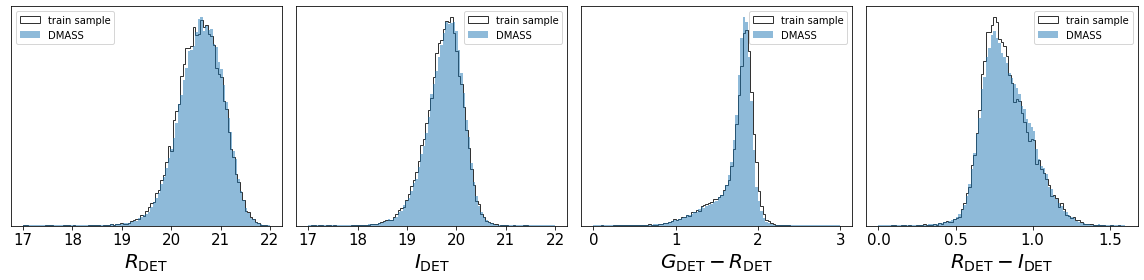

In [40]:
weights = dmass_spt['CMASS_PROB'] * dmass_spt['SYS_WEIGHT']
X_dmass,_ = mixing_color(dmass_spt)

# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_dmass], 
                   labels = [r'${R_{\rm DET}}$', r'${I_{\rm DET}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$'], 
                   ranges = [(17,22),(17,22),(0,3),(0.0,1.6)], 
                   name = ['train sample', 'DMASS'], 
                   weight = [None,weights], 
                   color = ['black','tab:blue'],
                   nbins=100, filename = 'DET_cmass.pdf')

In [26]:
dmass_spt = fitsio.read('../output/test/train_cat/y3/dmass_sys_weight_val_FULL_lin.fits')

weight = dmass_spt['CMASS_PROB'] * dmass_spt['SYS_WEIGHT']
name = [r'${R_{\rm DET}}$', r'${I_{\rm DET}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$']
xbins = 100
data = [X_cmass_true, X_sample_dmass]
color = ['black','blue']

#axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.5, color =color[j], density=True)

if j == 0:
    axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.5, color =color[j], density=True, histtype='step')
else:
    axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.5, color =color[j], density=True)

NameError: name 'axes' is not defined

In [17]:
def hist_plot( true, data1, labels = None, ranges = None, name = None, weight = [None,None], nbins=100, prefix= 'default', outdir='./'):


    if labels == None:
        print(" always label your axes! you must populate the 'labels' keyword with one entry for each dimension of the data.")
        stop
    else:
        ndim = len(labels)

    if ranges == None:
        # try to figure out the correct axis ranges.
        print("Using central 98% to set range.")
        ranges = []
        for i in range(ndim):
            ranges.append( np.percentile(real_data[:,i],[1.,99.]) )

    fig,axes = plt.subplots(nrows=1, ncols= ndim, figsize= (4*ndim, 4) )

    #print weight[0], weight[1].size, data1[:,0].size
    for i in range(ndim):
        xbins = np.linspace(ranges[i][0],ranges[i][1], nbins)
        axes[i].hist(true[:,i],bins=xbins,normed=True, label=name[0], weights=weight[0], alpha = 0.5, color ='grey')
        Nhist, _, _=axes[i].hist(data1[:,i],bins=xbins,normed=True,alpha=1.0,label=name[1], weights=weight[1], histtype='step', color='k', lw=1)
        axes[i].set_xlabel(labels[i], fontsize = 20)
        #axes[i].hist(data2[:,i],bins=xbins,normed=True,alpha=0.5,label='data2')
        if i == 0 :
            axes[i].set_yticks([0, Nhist.max()])
            axes[i].set_yticklabels(['$0$', '$1$'])
            axes[i].set_ylabel(r'$n_{\rm gal}$', fontsize=20)
        axes[i].get_yaxis().set_visible(False)
        axes[i].tick_params(labelsize=15)
        axes[i].legend(loc='best',fontsize = 15)

    axes[0].get_yaxis().set_visible(True)
    
    
    
    filename = outdir+"/"+prefix+"diagnostic_histograms_1d.pdf"
    print("writing output plot to: "+filename)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.5);
    fig.savefig(filename)
    #plt.close(fig)

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: weights should have the same shape as x

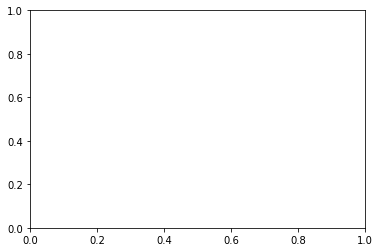

In [25]:
dmass_spt = fitsio.read('../output/test/train_cat/y3/dmass_sys_weight_val_FULL_lin.fits')
X_dmass,_ = mixing_color(dmass_spt)

weight = dmass_spt['CMASS_PROB'] * dmass_spt['SYS_WEIGHT'] 
ranges = [(17,22),(17,22),(0,3),(0.0,1.6)]

# Plotting all
labels = [r'${R_{\rm DET}}$', r'${I_{\rm DET}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$']
ranges =  [[17,22], [16,21], [-.5,2], [-.5,1.5]]
plt.hist( X_cmass_true, X_sample_dmass, labels = labels, range = ranges,\
                         name =[r'{\rm train}',r'{\rm DMASS}' ], \
                   weights=[None, weight], histtype = 'step')

In [19]:
?plt.hist

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*.  The return value is a tuple
(*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
*patches1*,...]) if the input contains multiple data.  See the
documentation of the *weights* parameter to draw a histogram of
already-binned data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported.

The *bins*, *range*, *weights*, and *density* parameters behave as in
`numpy.histogram`.

P

AttributeError: 'Rectangle' object has no property 'normed'

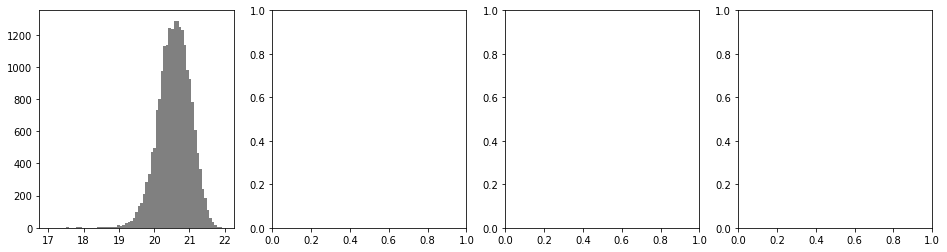

In [18]:
dmass_spt = fitsio.read('../output/test/train_cat/y3/dmass_sys_weight_val_FULL_lin.fits')

#X_train, Xcov_train = mixing_color(train_sample)
#X_test,_ = mixing_color(dmass_spt)

weight = dmass_spt['CMASS_PROB'] * dmass_spt['SYS_WEIGHT'] 
# Plotting all
labels = [r'${R_{\rm DET}}$', r'${I_{\rm DET}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$']
ranges =  [[17,22], [16,21], [-.5,2], [-.5,1.5]]
hist_plot( X_cmass_true, X_sample_dmass, labels = labels, ranges = ranges,\
                         name =[r'{\rm train}',r'{\rm DMASS}' ], nbins=70, \
                   weight=[None, weight], outdir = '../paper_figure/', prefix='validation_test')

In [12]:
?doVisualization_1d

Signature:
doVisualization_1d(
    data=None,
    labels=None,
    ranges=None,
    name=None,
    weight=[None, None],
    color=['grey', 'tab:blue', 'tab:orange', 'tab:green'],
    nbins=100,
    filename=None,
)
Docstring: <no docstring>
File:      ~/DMASSY3/code_py3/xd.py
Type:      function


In [22]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_no_true, X_sample_nodmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = [(17,24),(17,24),(0,3),(0.0,1.6)], 
                   name = ['train sample', 'model sample'], 
                   histtype = ['step','stepfilled'],
                   color = ['black','blue'],
                   weight = [None,None], 
                   nbins=100, filename = 'DET_nocmass.pdf')